# Data Science: Predicting NBA Games Using ML Algorithms

In [1310]:
#importing the packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import itertools

# importing all sklearn packages
import sklearn.datasets as datasets
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error, confusion_matrix   
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
 

In [1311]:
games_details = pd.read_csv('data/games_details.csv', low_memory=False)
games = pd.read_csv("data/games.csv",parse_dates=["GAME_DATE_EST"],infer_datetime_format=True)
# parsing our dates and putting them into datetime format
games = games.drop_duplicates().sort_values("GAME_DATE_EST").set_index(["GAME_DATE_EST"])
# dropping any duplicate dates, and sorting values so that earliest date comes first. setting the date as our index
ranking = pd.read_csv("data/ranking.csv",parse_dates=["STANDINGSDATE"])
ranking.sort_values("STANDINGSDATE", inplace=True)
players = pd.read_csv('data/players.csv')
teams = pd.read_csv('data/teams.csv')

In [1312]:
print(games_details.columns)
print(games.columns)
print(players.columns)
print(teams.columns)
print(ranking.columns)

Index(['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID',
       'PLAYER_NAME', 'NICKNAME', 'START_POSITION', 'COMMENT', 'MIN', 'FGM',
       'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS',
       'PLUS_MINUS'],
      dtype='object')
Index(['GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID',
       'SEASON', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home', 'FT_PCT_home',
       'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away', 'PTS_away',
       'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away',
       'HOME_TEAM_WINS'],
      dtype='object')
Index(['PLAYER_NAME', 'TEAM_ID', 'PLAYER_ID', 'SEASON'], dtype='object')
Index(['LEAGUE_ID', 'TEAM_ID', 'MIN_YEAR', 'MAX_YEAR', 'ABBREVIATION',
       'NICKNAME', 'YEARFOUNDED', 'CITY', 'ARENA', 'ARENACAPACITY', 'OWNER',
       'GENERALMANAGER', 'HEADCOACH', 'DLEAGUEAFFILIATION'],
      dtype='object')
Index(

# Visualisation

In [1313]:
#average points by the players
avg_points = games_details[["PLAYER_NAME", "PTS"]].groupby("PLAYER_NAME").mean()
avg_points.head()

,PTS
PLAYER_NAME,
A.J. Guyton,4.000000
A.J. Lawson,8.000000
AJ Hammons,2.827586
AJ Price,6.086379
Aamir Simms,2.000000


In [1314]:
total_points = games_details[["PLAYER_NAME", "PTS"]].groupby("PLAYER_NAME").sum()
# total_points

In [1315]:
num_appearances = games_details[["PLAYER_NAME", "GAME_ID"]].groupby('PLAYER_NAME').count()
num_appearances = num_appearances[num_appearances.GAME_ID > 1400]
# num_appearances

In [1316]:
df = pd.merge(avg_points, total_points, on="PLAYER_NAME")
df2 = pd.merge(df, num_appearances, on="PLAYER_NAME")
df2 = df2.reset_index()
df2.rename(columns={'PTS_x': "AVERAGE_PTS","PTS_y": "TOTAL_POINTS", "GAME_ID": "APPEARANCES"}, inplace=True)
# df2.sort_values("APPEARANCES")

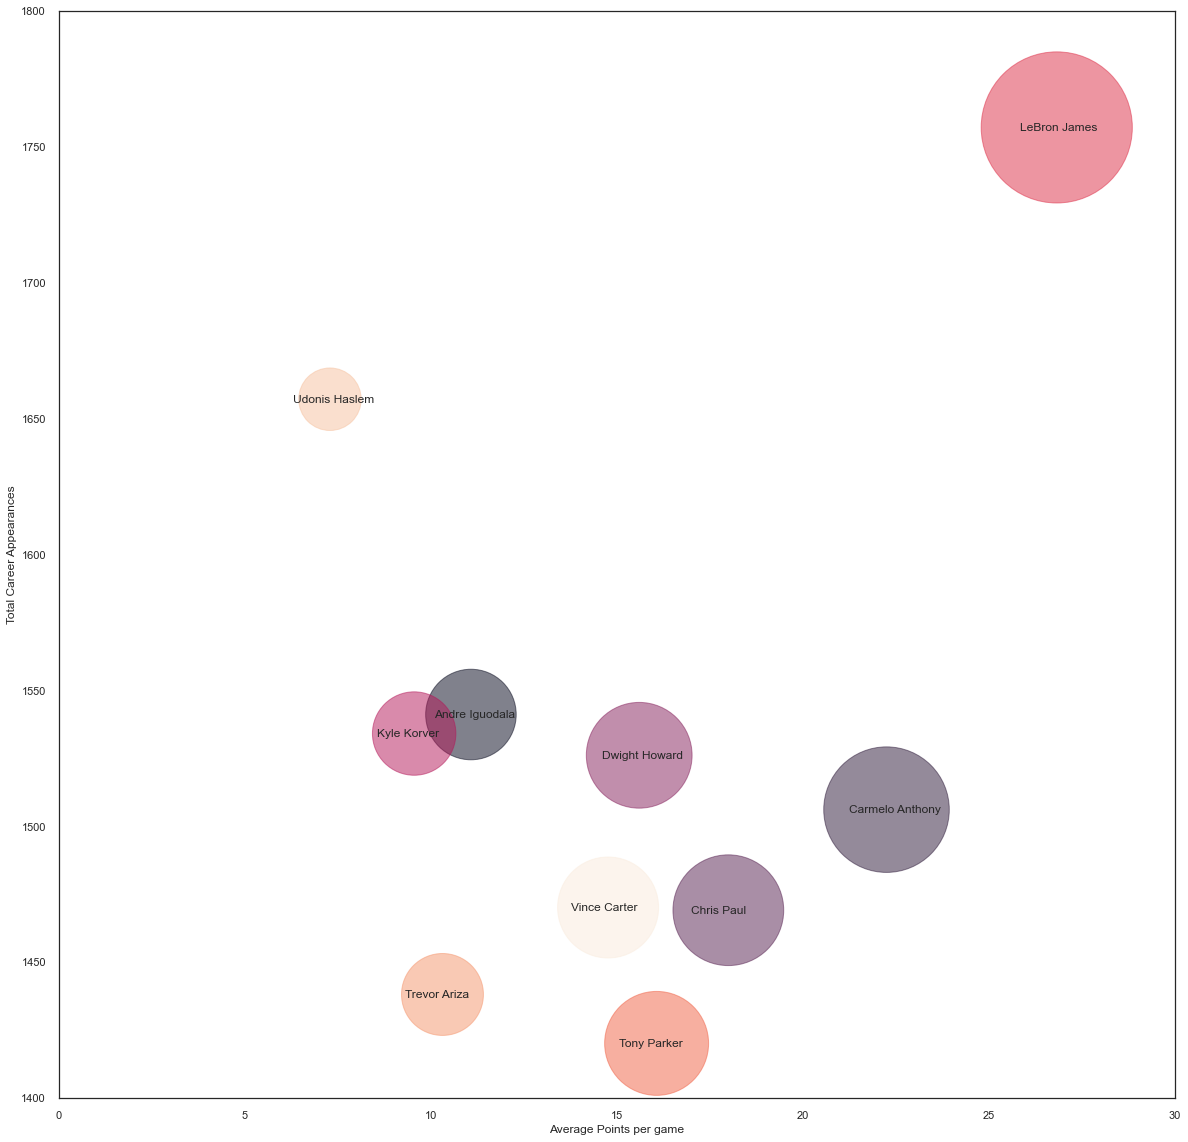

In [1317]:
plt.figure(figsize=(20,20))
plt.scatter(df2.AVERAGE_PTS, df2.APPEARANCES, s=df2.TOTAL_POINTS/2, alpha=0.5, c=df2.index.to_series())
plt.xlim(0, 30)
plt.ylim(1400, 1800)
plt.xlabel("Average Points per game")
plt.ylabel("Total Career Appearances")

for x,y,z in zip(df2.AVERAGE_PTS, df2.APPEARANCES, df2.PLAYER_NAME):
    plt.annotate(z,xy=(x-1, y-1))
#conclusion 
#LeBron James has been dominant player with appearances aabove 1400

In [1318]:
games.columns

Index(['GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID',
       'SEASON', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home', 'FT_PCT_home',
       'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away', 'PTS_away',
       'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away',
       'HOME_TEAM_WINS'],
      dtype='object')

In [1319]:
points_home = games["PTS_home"]
points_away = games["PTS_away"]

Text(0, 0.5, 'Frequency')

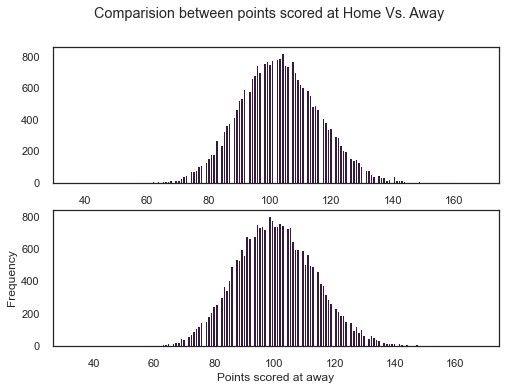

In [1320]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Comparision between points scored at Home Vs. Away')
ax1.hist(points_home, bins = int(np.sqrt(len(points_home))))
ax2.hist(points_away, bins = int(np.sqrt(len(points_away))))
plt.xlabel("Points scored at away")
plt.ylabel("Frequency")

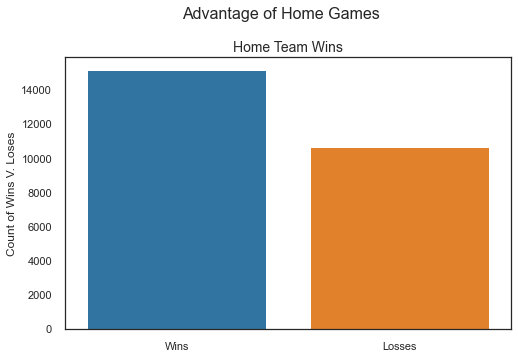

In [1321]:
#home advantage graph
home_points = games["PTS_home"]
away_points = games["PTS_away"]
points = (home_points + away_points)/2

#prepare plot labels
label_team= ["Home", "Away"]
values_team = [home_points, away_points]

#--------------------------Bar Plots--------------------------------------#
fig, ax = plt.subplots(1, figsize=(8,5))

# because I want to do side-by-side graphs, I create to axes.
sn.barplot(ax = ax, x=games.HOME_TEAM_WINS.value_counts().index, y=games.HOME_TEAM_WINS.value_counts(), order = [1,0], palette="tab10")
ax.set_ylabel("Count of Wins V. Loses", size=12)
ax.set_title("Home Team Wins", size=14)
ax.set_xticklabels(['Wins', 'Losses'])

plt.suptitle("Advantage of Home Games", size=16, y=1.02)
plt.show()

c:\users\tenzi\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


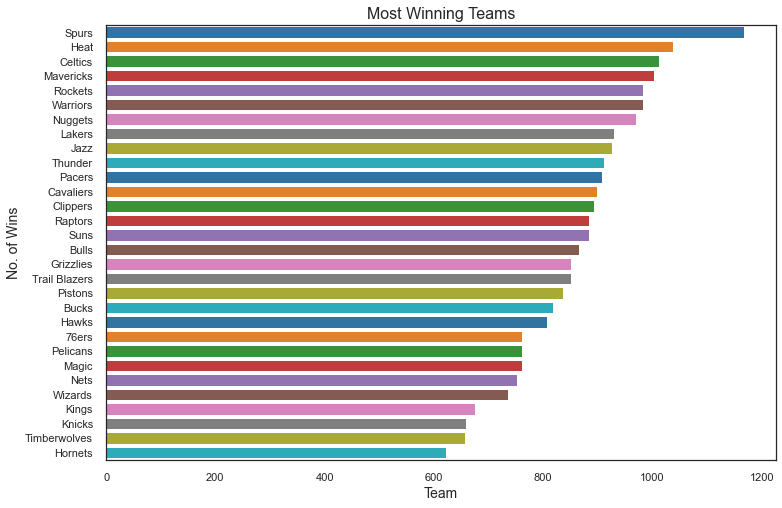

In [1322]:
#most dominant team in the NBA
winners = np.where(games['HOME_TEAM_WINS'] == 1, games['HOME_TEAM_ID'], games['VISITOR_TEAM_ID'])
winners = pd.DataFrame(winners, columns=['TEAM_ID'])
winners = winners.merge(teams[['TEAM_ID', 'NICKNAME']], on='TEAM_ID')['NICKNAME'].value_counts().to_frame().reset_index()
winners.columns = ['TEAM NAME', 'Number of wins']

#seaborn to plot the graph
plt.figure(figsize=(12, 8))
sn.barplot(winners['Number of wins'], winners['TEAM NAME'], palette="tab10")

#labels
plt.title("Most Winning Teams", size=16)
plt.xlabel("Team", size=14)
plt.ylabel("No. of Wins", size=14)
plt.show()

c:\users\tenzi\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


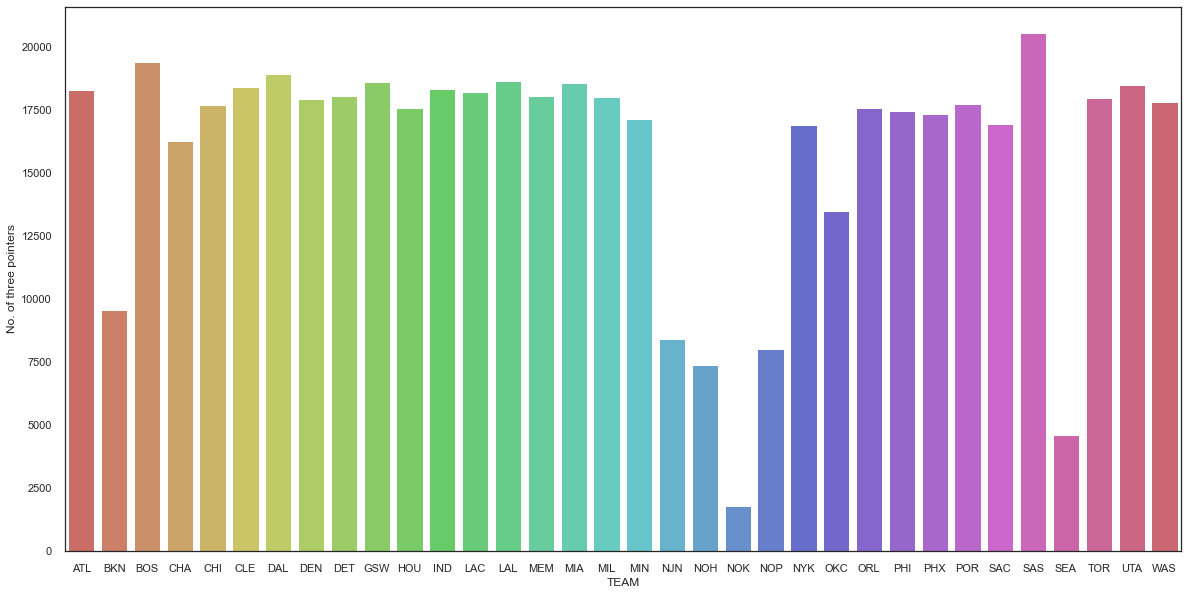

In [1323]:
three_points = games_details[["TEAM_ABBREVIATION", "FG3M"]].groupby("TEAM_ABBREVIATION").count()
three_points = three_points.rename(columns={"TEAM_ABBREVIATION": "TEAMS", "FG3M": "3 POINTS MADE"})
three_points = three_points.reset_index()
# three_points.sort_values("3 POINTS MADE")

plt.figure(figsize=(20, 10))
sn.barplot(three_points["TEAM_ABBREVIATION"], three_points["3 POINTS MADE"], palette=("hls"))
plt.xlabel("TEAM")
plt.ylabel("No. of three pointers")
plt.show()

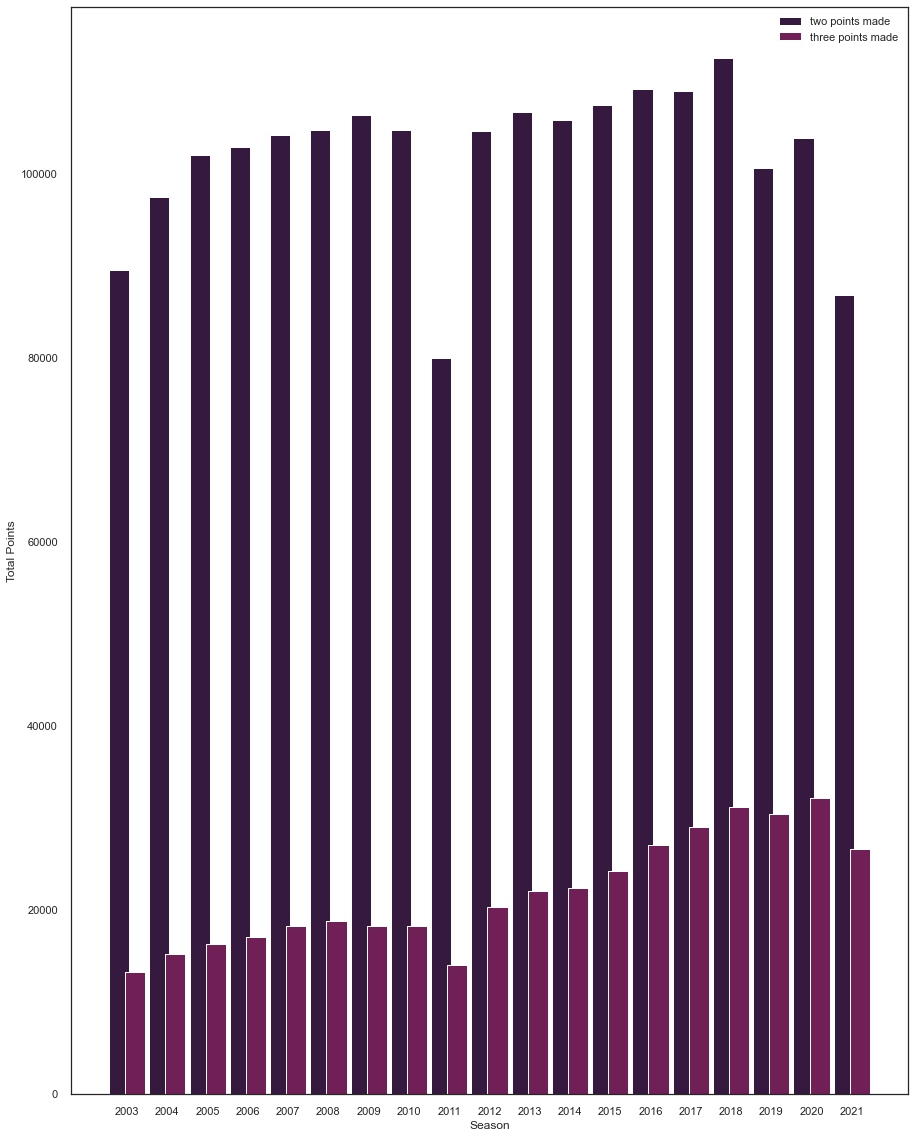

In [1324]:
merge_data = pd.merge(games_details, games, how="inner", on="GAME_ID")

two_vs_three = merge_data[["SEASON", "TEAM_CITY", "FGM", "FG3M"]].groupby(["SEASON"]).sum()
two_vs_three["FG2M"] = two_vs_three.apply(lambda x: x["FGM"] - x["FG3M"], axis=1)
two_vs_three = two_vs_three.reset_index()

#plot the graph here
season = two_vs_three["SEASON"]
two_points = two_vs_three["FGM"]
three_points = two_vs_three["FG3M"]

plt.figure(figsize=(15,20))
x_axis = np.arange(len(season))

# Multi bar Chart
plt.bar(x_axis -0.2, two_points, width=0.5, label = 'two points made')
plt.bar(x_axis +0.2, three_points, width=0.5, label = 'three points made')

# Xticks

plt.xticks(x_axis, season)
plt.xlabel("Season")
plt.ylabel("Total Points")
# Add legend
plt.legend()
plt.show()


#conclusion
#while the number of two points made remain almost same every year but the number of three points made has increased over the years

In [1325]:
total_three_points = merge_data[["PLAYER_NAME", "FG3M"]].groupby("PLAYER_NAME").sum()
three = total_three_points.reset_index()
top_10= three.nlargest(10, ["FG3M"])
#plot the graph
#top ten best shooter in the NBA
top_10.reset_index(drop=True, inplace=True)
top_10


,PLAYER_NAME,FG3M
0,Stephen Curry,3788.0
1,James Harden,3068.0
2,Kyle Korver,2856.0
3,LeBron James,2599.0
4,Damian Lillard,2443.0
5,Klay Thompson,2350.0
6,JR Smith,2328.0
7,JJ Redick,2265.0
8,Jamal Crawford,2252.0
9,Ray Allen,2235.0


## Data Manipulation

In [1326]:
#merging the games and ranking files to get statistics of different teams at different games.
ranking.set_index("STANDINGSDATE",inplace=True)
games = pd.merge_asof(games, ranking.add_suffix("_homeTeam"), left_index=True, right_index=True, left_by="HOME_TEAM_ID", right_by='TEAM_ID'+"_homeTeam", allow_exact_matches=False)
games = pd.merge_asof(games, ranking.add_suffix("_awayTeam"),left_index=True, right_index=True, left_by="VISITOR_TEAM_ID", right_by='TEAM_ID'+"_awayTeam", allow_exact_matches=False)
games.drop(["SEASON_ID_awayTeam","TEAM_ID_awayTeam","TEAM_ID_homeTeam"],axis=1,inplace=True)
games.rename(columns={"SEASON_ID_homeTeam":"SEASON_ID"},inplace=True)
print(games.shape)

(25796, 41)


In [1327]:
games.columns

Index(['GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID',
       'SEASON', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home', 'FT_PCT_home',
       'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away', 'PTS_away',
       'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away',
       'HOME_TEAM_WINS', 'LEAGUE_ID_homeTeam', 'SEASON_ID',
       'CONFERENCE_homeTeam', 'TEAM_homeTeam', 'G_homeTeam', 'W_homeTeam',
       'L_homeTeam', 'W_PCT_homeTeam', 'HOME_RECORD_homeTeam',
       'ROAD_RECORD_homeTeam', 'RETURNTOPLAY_homeTeam', 'LEAGUE_ID_awayTeam',
       'CONFERENCE_awayTeam', 'TEAM_awayTeam', 'G_awayTeam', 'W_awayTeam',
       'L_awayTeam', 'W_PCT_awayTeam', 'HOME_RECORD_awayTeam',
       'ROAD_RECORD_awayTeam', 'RETURNTOPLAY_awayTeam'],
      dtype='object')

In [1328]:
#removing the redundant and uncessary columns
games.drop(columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID','GAME_STATUS_TEXT','TEAM_ID_home', 'TEAM_ID_away', 'LEAGUE_ID_homeTeam', 'SEASON_ID','RETURNTOPLAY_homeTeam', 'RETURNTOPLAY_awayTeam', 'LEAGUE_ID_awayTeam'], inplace = True)

In [1329]:
# we can assume that a team is likely to win by 50% percentage if the team hasn't played a game. 
# So we set it to 0.5 if the game played is 0
def winning_percentage(row):
    if row['G_homeTeam'] == 0:
        row['W_PCT_homeTeam'] = .500
    if row['G_awayTeam'] == 0:
        row['W_PCT_awayTeam'] = .500
    return row
games = games.apply(winning_percentage, axis = 1)

In [1330]:
games.dropna(inplace = True)

## Feature Generations

In [1331]:
#finding all the nba teams
teams = games.TEAM_homeTeam.unique()
teams

array(['Utah', 'Memphis', 'Washington', 'Dallas', 'Phoenix', 'Detroit',
       'Portland', 'Sacramento', 'Miami', 'Toronto', 'Seattle',
       'New Orleans', 'Indiana', 'Boston', 'Atlanta', 'L.A. Lakers',
       'San Antonio', 'Philadelphia', 'Minnesota', 'New York', 'Chicago',
       'Denver', 'Golden State', 'Orlando', 'Houston', 'L.A. Clippers',
       'New Jersey', 'Milwaukee', 'Cleveland', 'Charlotte',
       'New Orleans/Oklahoma City', 'Oklahoma City', 'Brooklyn',
       'LA Clippers'], dtype=object)

In [1332]:
game_stats = ['PTS', 'FG_PCT', 'FT_PCT',
       'FG3_PCT', 'AST', 'REB']

In [1333]:
for stat in game_stats:
    print(stat+'_home')

PTS_home
FG_PCT_home
FT_PCT_home
FG3_PCT_home
AST_home
REB_home


In [1334]:
for stat in game_stats:
    for team in teams:
        x = games.loc[(games.TEAM_homeTeam == team) | (games.TEAM_awayTeam == team), :]
        rolling = pd.Series(np.where(x.TEAM_homeTeam == team, x[stat+'_home'], x[stat+'_away'])).rolling(10).mean()
        rolling.index = x.index
        trues = x.TEAM_homeTeam == team
        games.loc[games.TEAM_homeTeam == team, stat+'_rolling_home'] = rolling[trues]
        games.loc[games.TEAM_awayTeam == team, stat+'_rolling_away'] = rolling[~trues]

In [1335]:
games.HOME_RECORD_awayTeam.isna().sum()

0

In [1336]:
#calculating home team's home record
games['HOME_RECORD_homeTeam'] = games.HOME_RECORD_homeTeam.str.split('-')
games['home_wins_home_team'] = games.HOME_RECORD_homeTeam.apply(lambda x:int(x[0]))
games['home_losses_home_team'] = games.HOME_RECORD_homeTeam.apply(lambda x:int(x[1]))

In [1337]:
#calculating home team's home record
games['ROAD_RECORD_homeTeam'] = games.ROAD_RECORD_homeTeam.str.split('-')
games['road_wins_home_team'] = games.ROAD_RECORD_homeTeam.apply(lambda x:int(x[0]))
games['road_losses_home_team'] = games.ROAD_RECORD_homeTeam.apply(lambda x:int(x[1]))

In [1338]:
#calculating away team's home record
games['HOME_RECORD_awayTeam'] = games.HOME_RECORD_awayTeam.str.split('-')
games['home_wins_away_team'] = games.HOME_RECORD_awayTeam.apply(lambda x:int(x[0]))
games['home_losses_away_team'] = games.HOME_RECORD_awayTeam.apply(lambda x:int(x[1]))

In [1339]:
#calculating away team's road record
games['ROAD_RECORD_awayTeam'] = games.ROAD_RECORD_awayTeam.str.split('-')
games['road_wins_away_team'] = games.ROAD_RECORD_awayTeam.apply(lambda x:int(x[0]))
games['road_losses_away_team'] = games.ROAD_RECORD_awayTeam.apply(lambda x:int(x[1]))

In [1340]:
conditions = [(games.home_wins_home_team == 0) & (games.home_losses_home_team == 0), (games.home_wins_home_team > 0) & (games.home_losses_home_team == 0)]
values = [0.5, 1.0]
games['home_team_home_win_pct'] = np.select(conditions, values, default = games.home_wins_home_team/(games.home_wins_home_team+games.home_losses_home_team))

In [1341]:
# games['home_team_home_win_pct']

In [1342]:
#calcualint win percentage for home team and the away team
games['home_team_away_win_pct'] = np.select([(games.road_wins_home_team == 0) & (games.road_losses_home_team == 0), (games.road_wins_home_team > 0) & (games.road_losses_home_team == 0)], [0.5, 1.0], default = games.road_wins_home_team/(games.road_wins_home_team+games.road_losses_home_team))
games['away_team_home_win_pct'] = np.select( [(games.home_wins_away_team == 0) & (games.home_losses_away_team == 0), (games.home_wins_away_team > 0) & (games.home_losses_away_team == 0)], [0.5, 1.0], default = games.home_wins_away_team/(games.home_wins_away_team+games.home_losses_away_team))
games['away_team_away_win_pct'] = np.select([(games.road_wins_away_team == 0) & (games.road_losses_away_team == 0), (games.road_wins_away_team > 0) & (games.road_losses_away_team == 0)], [0.5, 1.0], default = games.road_wins_away_team/(games.road_wins_away_team+games.road_losses_away_team))

In [1343]:
games.columns=[x.lower() for x in games.columns]

In [1344]:
games.dropna(inplace=True)

In [1345]:
games

,game_id,season,pts_home,fg_pct_home,ft_pct_home,fg3_pct_home,ast_home,reb_home,pts_away,fg_pct_away,ft_pct_away,fg3_pct_away,ast_away,reb_away,home_team_wins,conference_hometeam,team_hometeam,g_hometeam,w_hometeam,l_hometeam,w_pct_hometeam,home_record_hometeam,road_record_hometeam,conference_awayteam,team_awayteam,...,road_record_awayteam,pts_rolling_home,pts_rolling_away,fg_pct_rolling_home,fg_pct_rolling_away,ft_pct_rolling_home,ft_pct_rolling_away,fg3_pct_rolling_home,fg3_pct_rolling_away,ast_rolling_home,ast_rolling_away,reb_rolling_home,reb_rolling_away,home_wins_home_team,home_losses_home_team,road_wins_home_team,road_losses_home_team,home_wins_away_team,home_losses_away_team,road_wins_away_team,road_losses_away_team,home_team_home_win_pct,home_team_away_win_pct,away_team_home_win_pct,away_team_away_win_pct
GAME_DATE_EST,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-11-14,20300117,2003,105.0,0.409,0.700,0.400,19.0,53.0,101.0,0.448,0.679,0.286,16.0,43.0,1,East,Miami,8,1,7,0.125,"[1, 2]","[0, 5]",East,Washington,...,"[1, 2]",82.4,92.8,0.3858,0.4395,0.7366,0.7134,0.3181,0.3308,15.6,20.6,44.3,44.6,1,2,0,5,2,2,1,2,0.333333,0.000000,0.500000,0.333333
2003-11-14,20300120,2003,77.0,0.392,0.737,0.385,22.0,40.0,85.0,0.451,0.679,0.222,16.0,38.0,0,West,Minnesota,9,5,4,0.556,"[2, 2]","[3, 2]",West,Utah,...,"[0, 4]",88.2,91.2,0.4387,0.4544,0.7523,0.7820,0.3747,0.2877,22.3,20.9,41.0,40.7,2,2,3,2,4,0,0,4,0.500000,0.600000,1.000000,0.000000
2003-11-14,20300115,2003,91.0,0.410,0.767,0.400,19.0,43.0,82.0,0.351,0.722,0.286,16.0,50.0,1,East,Boston,8,4,4,0.500,"[2, 2]","[2, 2]",East,Cleveland,...,"[0, 5]",88.7,89.5,0.4351,0.4405,0.7222,0.6874,0.2859,0.3291,21.5,23.3,42.9,45.7,2,2,2,2,2,1,0,5,0.500000,0.500000,0.666667,0.000000
2003-11-14,20300122,2003,94.0,0.500,0.929,0.385,29.0,48.0,64.0,0.338,0.778,0.250,10.0,34.0,1,West,Sacramento,8,4,4,0.500,"[3, 0]","[1, 4]",East,Toronto,...,"[0, 4]",101.4,75.3,0.4688,0.3821,0.7875,0.7709,0.4017,0.2969,27.6,17.8,39.8,40.8,3,0,1,4,4,0,0,4,1.000000,0.200000,1.000000,0.000000
2003-11-14,20300119,2003,100.0,0.493,0.628,0.333,21.0,43.0,96.0,0.375,0.750,0.316,26.0,51.0,1,East,Philadelphia,8,4,4,0.500,"[1, 2]","[3, 2]",West,San Antonio,...,"[1, 2]",93.2,86.4,0.4382,0.3806,0.7238,0.7503,0.3170,0.2891,19.6,18.3,38.3,46.8,1,2,3,2,4,2,1,2,0.333333,0.600000,0.666667,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-12,22101010,2021,134.0,0.558,0.710,0.390,21.0,44.0,125.0,0.500,0.857,0.394,27.0,33.0,1,West,Utah,66,41,25,0.621,"[23, 10]","[18, 15]",West,Sacramento,...,"[9, 24]",113.3,113.2,0.4736,0.4778,0.7406,0.7704,0.3718,0.3326,23.0,24.7,47.1,40.4,23,10,18,15,15,20,9,24,0.696970,0.545455,0.428571,0.272727
2022-03-12,22101009,2021,115.0,0.551,0.750,0.407,32.0,39.0,127.0,0.471,0.760,0.387,28.0,50.0,0,West,Denver,67,40,27,0.597,"[20, 12]","[20, 15]",East,Toronto,...,"[19, 15]",118.2,109.7,0.4974,0.4437,0.8029,0.7369,0.3286,0.3387,28.7,21.5,45.4,45.8,20,12,20,15,17,15,19,15,0.625000,0.571429,0.531250,0.558824
2022-03-12,22101008,2021,122.0,0.484,0.933,0.400,33.0,55.0,109.0,0.413,0.696,0.386,27.0,39.0,1,West,Golden State,67,45,22,0.672,"[27, 7]","[18, 15]",East,Milwaukee,...,"[18, 13]",116.3,124.6,0.4906,0.4889,0.7486,0.7670,0.3712,0.3894,28.4,25.6,42.8,48.8,27,7,18,15,24,12,18,13,0.794118,0.545455,0.666667,0.580645


In [1346]:
#calculating home wins by finding different between points scored at home and away
games['pts_diff'] = games['pts_home'] - games['pts_away']

In [1347]:
# finding performance of different teams (whether some teams are better or not)
games['team_disparity'] = games.w_pct_hometeam - games.w_pct_awayteam

In [1348]:
# getting dummies for home and away for each teams
games = pd.get_dummies(games, prefix=['Home', 'Away'], columns=['team_hometeam', 'team_awayteam'])

In [1349]:
# games.iloc[:, 55:121]

### Implementating Machine Learning algorithms

In [1381]:
# # Selecting Features
# games.columns.unique()
# print(games.columns.tolist())

In [1382]:
#removing all the nan values
games.dropna(inplace=True)

In [1383]:
#checking the number of missing values
games.isna().sum().sum()
games.columns

Index(['game_id', 'season', 'pts_home', 'fg_pct_home', 'ft_pct_home',
       'fg3_pct_home', 'ast_home', 'reb_home', 'pts_away', 'fg_pct_away',
       ...
       'Away_Orlando', 'Away_Philadelphia', 'Away_Phoenix', 'Away_Portland',
       'Away_Sacramento', 'Away_San Antonio', 'Away_Seattle', 'Away_Toronto',
       'Away_Utah', 'Away_Washington'],
      dtype='object', length=123)

In [1384]:
games[features]

,season,w_pct_hometeam,w_pct_awayteam,pts_rolling_home,pts_rolling_away,fg_pct_rolling_home,fg_pct_rolling_away,ft_pct_rolling_home,ft_pct_rolling_away,fg3_pct_rolling_home,fg3_pct_rolling_away,ast_rolling_home,ast_rolling_away,reb_rolling_home,reb_rolling_away,home_team_home_win_pct,away_team_away_win_pct,team_disparity,home_team_wins,Home_Atlanta,Home_Boston,Home_Brooklyn,Home_Charlotte,Home_Chicago,Home_Cleveland,...,Away_Golden State,Away_Houston,Away_Indiana,Away_L.A. Clippers,Away_L.A. Lakers,Away_LA Clippers,Away_Memphis,Away_Miami,Away_Milwaukee,Away_Minnesota,Away_New Jersey,Away_New Orleans,Away_New Orleans/Oklahoma City,Away_New York,Away_Oklahoma City,Away_Orlando,Away_Philadelphia,Away_Phoenix,Away_Portland,Away_Sacramento,Away_San Antonio,Away_Seattle,Away_Toronto,Away_Utah,Away_Washington
GAME_DATE_EST,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-11-14,2003,0.125,0.429,82.4,92.8,0.3858,0.4395,0.7366,0.7134,0.3181,0.3308,15.6,20.6,44.3,44.6,0.333333,0.333333,-0.304,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2003-11-14,2003,0.556,0.500,88.2,91.2,0.4387,0.4544,0.7523,0.7820,0.3747,0.2877,22.3,20.9,41.0,40.7,0.500000,0.000000,0.056,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2003-11-14,2003,0.500,0.250,88.7,89.5,0.4351,0.4405,0.7222,0.6874,0.2859,0.3291,21.5,23.3,42.9,45.7,0.500000,0.000000,0.250,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2003-11-14,2003,0.500,0.500,101.4,75.3,0.4688,0.3821,0.7875,0.7709,0.4017,0.2969,27.6,17.8,39.8,40.8,1.000000,0.000000,0.000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2003-11-14,2003,0.500,0.556,93.2,86.4,0.4382,0.3806,0.7238,0.7503,0.3170,0.2891,19.6,18.3,38.3,46.8,0.333333,0.333333,-0.056,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-12,2021,0.621,0.353,113.3,113.2,0.4736,0.4778,0.7406,0.7704,0.3718,0.3326,23.0,24.7,47.1,40.4,0.696970,0.272727,0.268,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2022-03-12,2021,0.597,0.545,118.2,109.7,0.4974,0.4437,0.8029,0.7369,0.3286,0.3387,28.7,21.5,45.4,45.8,0.625000,0.558824,0.052,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2022-03-12,2021,0.672,0.627,116.3,124.6,0.4906,0.4889,0.7486,0.7670,0.3712,0.3894,28.4,25.6,42.8,48.8,0.794118,0.580645,0.045,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1385]:
#spliting the data into train and test data
#we are using games from 2003 to 2019 as training data
#we use test data to predict seasons 2019 and 2020
games_train = games[(games["season"]>= 2003) & (games["season"] <=2019)]
games_test = games[(games["season"]>= 2020)]

In [1386]:
games.isna().sum().sum()
games.columns

Index(['game_id', 'season', 'pts_home', 'fg_pct_home', 'ft_pct_home',
       'fg3_pct_home', 'ast_home', 'reb_home', 'pts_away', 'fg_pct_away',
       ...
       'Away_Orlando', 'Away_Philadelphia', 'Away_Phoenix', 'Away_Portland',
       'Away_Sacramento', 'Away_San Antonio', 'Away_Seattle', 'Away_Toronto',
       'Away_Utah', 'Away_Washington'],
      dtype='object', length=123)

In [1387]:
features = ['season', 'w_pct_hometeam','w_pct_awayteam', 'pts_rolling_home', 'pts_rolling_away', 'fg_pct_rolling_home',
             'fg_pct_rolling_away', 'ft_pct_rolling_home', 'ft_pct_rolling_away', 'fg3_pct_rolling_home', 
             'fg3_pct_rolling_away', 'ast_rolling_home', 'ast_rolling_away', 'reb_rolling_home', 'reb_rolling_away',
             'home_team_home_win_pct', 'away_team_away_win_pct', 'team_disparity', 'home_team_wins', 'Home_Atlanta', 'Home_Boston', 
             'Home_Brooklyn', 'Home_Charlotte', 'Home_Chicago', 'Home_Cleveland', 'Home_Dallas', 'Home_Denver', 'Home_Detroit', 
             'Home_Golden State', 'Home_Houston', 'Home_Indiana', 'Home_L.A. Clippers', 'Home_L.A. Lakers', 'Home_LA Clippers', 
             'Home_Memphis', 'Home_Miami', 'Home_Milwaukee', 'Home_Minnesota', 'Home_New Jersey', 'Home_New Orleans',
             'Home_New Orleans/Oklahoma City', 'Home_New York', 'Home_Oklahoma City', 'Home_Orlando', 'Home_Philadelphia', 
             'Home_Phoenix', 'Home_Portland', 'Home_Sacramento', 'Home_San Antonio', 'Home_Seattle', 'Home_Toronto', 'Home_Utah',
             'Home_Washington', 'Away_Atlanta', 'Away_Boston', 'Away_Brooklyn', 'Away_Charlotte', 'Away_Chicago', 'Away_Cleveland',
             'Away_Dallas', 'Away_Denver', 'Away_Detroit', 'Away_Golden State', 'Away_Houston', 'Away_Indiana', 'Away_L.A. Clippers', 
             'Away_L.A. Lakers', 'Away_LA Clippers', 'Away_Memphis', 'Away_Miami', 'Away_Milwaukee', 'Away_Minnesota',
             'Away_New Jersey', 'Away_New Orleans', 'Away_New Orleans/Oklahoma City', 'Away_New York', 'Away_Oklahoma City',
             'Away_Orlando', 'Away_Philadelphia', 'Away_Phoenix', 'Away_Portland', 'Away_Sacramento', 'Away_San Antonio', 
             'Away_Seattle', 'Away_Toronto', 'Away_Utah', 'Away_Washington']

In [1388]:
games_train_filtered = games_train[features]
games_test_filtered = games_test[features]

In [1389]:
games_train_filtered.dropna(inplace=True)
games_test_filtered.dropna(inplace=True)

<ipython-input-1389-6cea8a8bfb66>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_train_filtered.dropna(inplace=True)
<ipython-input-1389-6cea8a8bfb66>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_test_filtered.dropna(inplace=True)


In [1412]:
X_train = games_train_filtered.drop("home_team_wins", axis=1)
y_train = games_train_filtered["home_team_wins"].values.reshape(-1, 1)
print(X_train.shape, y_train.shape)

(23187, 86) (23187, 1)


In [1413]:
X_test = games_test_filtered.drop("home_team_wins", axis=1)
y_test = games_test_filtered["home_team_wins"].values.reshape(-1, 1)
print(X_test.shape, y_test.shape)

(2325, 86) (2325, 1)


#### Logistical Regression

In [1414]:
# scaled X_train and X_test to make variables similary scaled and centered
X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [1415]:
logistical_model = LogisticRegression()
logistical_model.fit(X_train_scaled, y_train)

c:\users\tenzi\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [1416]:
logistic_train_score = logistical_model.score(X_train_scaled, y_train)
logistic_test_score = logistical_model.score(X_test_scaled, y_test)
print(f"Logistic Regressiong score on training data:", logistic_train_score)
print(f"Logistic Regressiong score on test data:", logistic_test_score)

Logistic Regressiong score on training data: 0.6862466037003493
Logistic Regressiong score on test data: 0.6537634408602151


In [1417]:
logistic_predictions = classifier.predict(X_test_scaled)
logistic_accuracy = pd.DataFrame({"Prediction": list(logistic_predictions), "Actual": y_test.ravel()}).reset_index(drop=True)
logistic_accuracy["correct"] =logistic_accuracy.Prediction== logistic_accuracy.Actual
logistic_accuracy.tail(15)

,Prediction,Actual,correct
2310,1,0,False
2311,1,1,True
2312,0,0,True
2313,1,1,True
2314,1,1,True
2315,0,1,False
2316,0,1,False
2317,1,1,True
2318,1,0,False
2319,0,1,False


In [1418]:
#ploting confusion matrix
def confusion_visualisation(dataframe, subplot_nums, score, title):
    names = dataframe.columns
    ax = fig.add_subplot(subplot_nums)
    
    cax = ax.matshow(dataframe, cmap=plt.get_cmap('RdPu'))
    fig.colorbar(cax)
    
    ticks = np.arange(0,len(dataframe.columns),1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(dataframe.columns, rotation = 90, fontsize = 10)
    ax.set_yticklabels(dataframe.columns, fontsize = 10)

    score_formatted = "{:.2%}".format(score)
     
    plt.title(f'''
    {title}

    Score: {score_formatted}
    ''', y=1.12, fontsize = 16, fontweight='bold')
    plt.xlabel('Predicted', fontweight='bold', fontsize = 14)
    ax.xaxis.set_label_position('top')
    plt.ylabel('Actual', fontweight='bold', fontsize = 14)

    for i in range(len(dataframe.columns)):
        for j in range(len(dataframe.columns)):
            text = ax.text(j, i, dataframe.iloc[i, j],
                           ha="center", va="center", color="black", fontsize = 14)

In [1419]:
#creating a confusion matrix to see the win and lose
logistic_y_actual = pd.Series(y_test.ravel(), name="Actual")
logistic_y_predict = pd.Series(logistic_predictions, name="Predicted")

logistic_cm= pd.crosstab(logistic_y_actual, logistic_y_predict)
logistic_cm.columns = ["Win", "Lose"]
logistic_cm.rename(index={
    logistic_cm.index[0]: "Win",
    logistic_cm.index[1]: "Lose",
}, inplace=True)
logistic_cm

,Win,Lose
Actual,,
Win,554,493
Lose,312,966


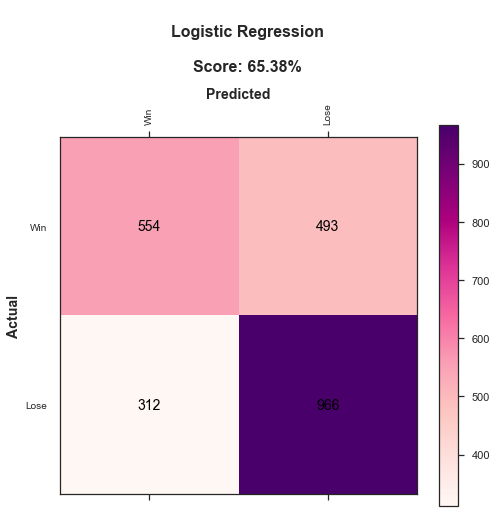

In [1420]:
fig = plt.figure(figsize=(8,7))
confusion_visualisation(logistic_cm, 111, logistic_test_score, "Logistic Regression")
plt.show()

#### Support Vector Machine

In [1421]:
#SVM
svm_model = SVC(kernel="linear")
svm_model.fit(X_trained_scaled, y_train)

c:\users\tenzi\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(kernel='linear')

In [1422]:
# SVM score model
svm_train_score = svm_model.score(X_train_scaled, y_train)
svm_test_score = svm_model.score(X_test_scaled, y_test)

print(f'SVM score on train data is {svm_train_score}')
print(f'SVM score on test data is {svm_test_score}')

SVM score on train data is 0.6855565618665631
SVM score on test data is 0.655483870967742


In [1423]:
# accuracy dataframe
svm_predictions = svm_model.predict(X_test_scaled)
svm_accuracy = pd.DataFrame({"Prediction": list(svm_predictions), "Actual": y_test.ravel()}).reset_index(drop=True)
svm_accuracy['Correct'] = svm_accuracy.Prediction == svm_accuracy.Actual
svm_accuracy.head(10)

,Prediction,Actual,Correct
0,1,1,True
1,0,1,False
2,1,0,False
3,0,0,True
4,1,0,False
5,1,0,False
6,1,1,True
7,0,0,True
8,0,0,True
9,0,1,False


In [1424]:
#creating a confusion matrix to see the win and lose
svm_y_actu = pd.Series(y_test.ravel(), name='Actual')
svm_y_pred = pd.Series(svm_predictions, name='Predicted')

svm_df_confusion = pd.crosstab(svm_y_actu, svm_y_pred)
svm_df_confusion.columns = ['Win', 'Lose']
svm_df_confusion.rename(index={
    svm_df_confusion.index[0]: 'Win',
    svm_df_confusion.index[1]: 'Lose',
}, inplace=True)
svm_df_confusion

,Win,Lose
Actual,,
Win,550,497
Lose,304,974


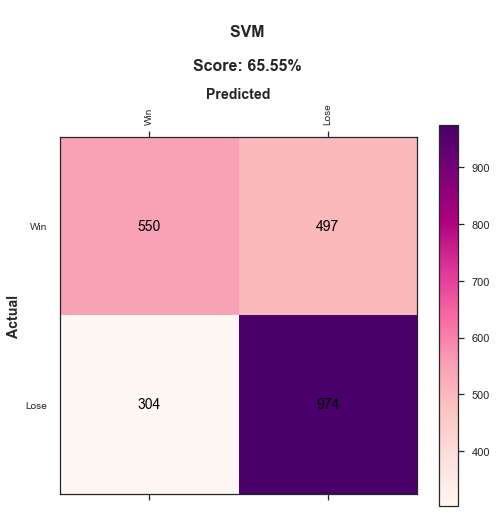

In [1425]:
fig = plt.figure(figsize = (8,7))
confusion_visualisation(svm_df_confusion, 111, svm_test_score, 'SVM')
plt.show()

#### KNN Classifier

In [1436]:
# scaled X_train and X_test to make variables similary scaled and centered
scaler = StandardScaler()
scaler.fit(X_train, y_train) 
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [1453]:
# creating our KNN classifier and setting it equal to knn with n_neighbors equals 1. We wanted this to be as precise as possible
# so we wanted it based on one neighbor
knn_model = KNeighborsClassifier(n_neighbors=61, n_jobs=-1)
# fitting our training data into our knn model
knn_model.fit(X_train_scaled, y_train)
# KNN score model
knn_train_score = knn_model.score(X_train_scaled, y_train)
knn_test_score = knn_model.score(X_test_scaled, y_test.ravel())
print(f'KNN score on train data is {knn_train_score}')
print(f'KNN score on test data is {knn_test_score}')


c:\users\tenzi\appdata\local\programs\python\python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


MemoryError: Unable to allocate 128. MiB for an array with shape (5788, 2899) and data type float64

In [1432]:
# accuracy dataframe
knn_predictions = knn_model.predict(X_test_scaled)
knn_accuracy = pd.DataFrame({"Prediction": list(knn_predictions), "Actual": y_test.ravel()}).reset_index(drop=True)
knn_accuracy['Correct'] = knn_accuracy.Prediction == knn_accuracy.Actual
knn_accuracy.head(15)

MemoryError: Unable to allocate 411. MiB for an array with shape (2325, 23187) and data type float64

In [1433]:
#creating a confusion matrix to see the win and lose
knn_y_actu = pd.Series(y_test.ravel(), name='Actual')
knn_y_pred = pd.Series(knn_predictions, name='Predicted')

knn_df_confusion = pd.crosstab(knn_y_actu, knn_y_pred)
knn_df_confusion.columns = ['Win', 'Lose']
knn_df_confusion.rename(index={
    knn_df_confusion.index[0]: 'Win',
    knn_df_confusion.index[1]: 'Lose',
}, inplace=True)
knn_df_confusion

,Win,Lose
Actual,,
Win,335,712
Lose,222,1056


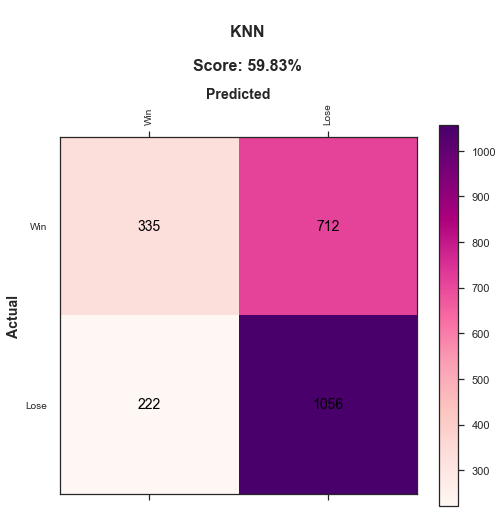

In [1434]:
fig = plt.figure(figsize = (8,7))
confusion_visualisation(knn_df_confusion, 111, knn_test_score, 'KNN')
plt.show()

#### Decision Tree Classifier

In [1439]:
dtree_model = DecisionTreeClassifier()
# fitting our training data into our knn model
dtree_model.fit(X_train, y_train)

# Decision Tree score model
dtree_train_score = dtree_model.score(X_train_scaled, y_train)
dtree_test_score =dtree_model.score(X_test_scaled, y_test)
print(f'KNN score on train data is {dtree_train_score}')
print(f'KNN score on test data is {dtree_test_score}')

KNN score on train data is 0.49872773536895676
KNN score on test data is 0.530752688172043


c:\users\tenzi\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\users\tenzi\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [1440]:
# accuracy dataframe
dtree_predictions = dtree_model.predict(X_test_scaled)
dtree_accuracy = pd.DataFrame({"Prediction": list(dtree_predictions), "Actual": y_test.ravel()}).reset_index(drop=True)
dtree_accuracy['Correct'] = dtree_accuracy.Prediction == dtree_accuracy.Actual
dtree_accuracy.head(15)

c:\users\tenzi\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


,Prediction,Actual,Correct
0,0,1,False
1,1,1,True
2,1,0,False
3,0,0,True
4,0,0,True
5,1,0,False
6,0,1,False
7,1,0,False
8,1,0,False
9,0,1,False


In [1441]:
#creating a confusion matrix to see the win and lose
dtree_y_actu = pd.Series(y_test.ravel(), name='Actual')
dtree_y_pred = pd.Series(knn_predictions, name='Predicted')

dtree_df_confusion = pd.crosstab(dtree_y_actu, dtree_y_pred)
dtree_df_confusion.columns = ['Win', 'Lose']
dtree_df_confusion.rename(index={
    dtree_df_confusion.index[0]: 'Win',
    dtree_df_confusion.index[1]: 'Lose',
}, inplace=True)
dtree_df_confusion

,Win,Lose
Actual,,
Win,335,712
Lose,222,1056


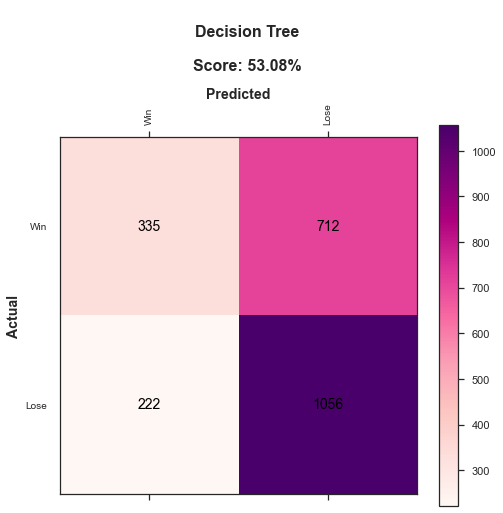

In [1442]:
fig = plt.figure(figsize = (8,7))
confusion_visualisation(dtree_df_confusion, 111, dtree_test_score, 'Decision Tree')
plt.show()

#### Random Forest Classifier

In [1443]:
# create a Random Forest Classifier, with our random state equaling 42
randomforest_model=RandomForestClassifier(max_depth = None, min_samples_leaf = 1, min_samples_split = 2, random_state = 42, n_jobs=-1)
randomforest_model.fit(X_train,y_train)
# predicitng our dependent variable using our model and the test data for our independent variable
randomforest_train_score = randomforest_model.score(X_train_scaled, y_train)
randomforest_test_score =randomforest_model.score(X_test_scaled, y_test)
print(f'Random Forest score on train data is {randomforest_train_score}')
print(f'Random Forest score on test data is {randomforest_test_score}')

<ipython-input-1443-926824c0edf0>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  randomforest_model.fit(X_train,y_train)


Random Forest score on train data is 0.5746754647000475
Random Forest score on test data is 0.5806451612903226


c:\users\tenzi\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\users\tenzi\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [1444]:
# accuracy dataframe
randomforest_predictions = randomforest_model.predict(X_test_scaled)
randomforest_accuracy = pd.DataFrame({"Prediction": list(randomforest_predictions), "Actual": y_test.ravel()}).reset_index(drop=True)
randomforest_accuracy['Correct'] = randomforest_accuracy.Prediction == randomforest_accuracy.Actual
randomforest_accuracy.head(15)

c:\users\tenzi\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,Prediction,Actual,Correct
0,1,1,True
1,0,1,False
2,0,0,True
3,1,0,False
4,0,0,True
5,1,0,False
6,1,1,True
7,0,0,True
8,0,0,True
9,0,1,False


In [1445]:
#creating a confusion matrix to see the win and lose
randomforest_y_actu = pd.Series(y_test.ravel(), name='Actual')
randomforest_y_pred = pd.Series(randomforest_predictions, name='Predicted')

randomforest_df_confusion = pd.crosstab(randomforest_y_actu, randomforest_y_pred)
randomforest_df_confusion.columns = ['Win', 'Lose']
randomforest_df_confusion.rename(index={
    randomforest_df_confusion.index[0]: 'Win',
    randomforest_df_confusion.index[1]: 'Lose',
}, inplace=True)
randomforest_df_confusion

,Win,Lose
Actual,,
Win,473,574
Lose,401,877


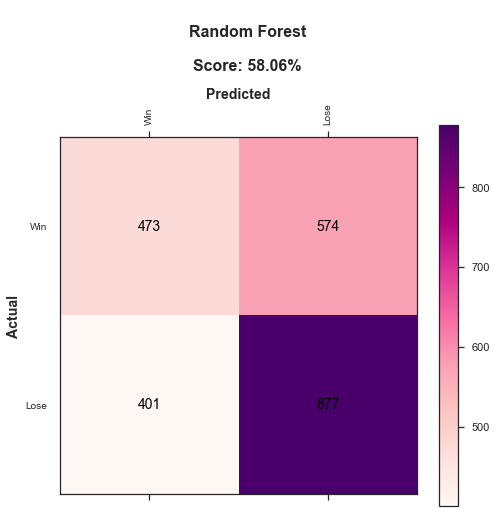

In [1446]:
fig = plt.figure(figsize = (8,7))
confusion_visualisation(randomforest_df_confusion, 111, randomforest_test_score, 'Random Forest')
plt.show()

In [1447]:
train_accuracy = [logistic_train_score, svm_train_score, knn_train_score, dtree_train_score, randomforest_train_score]
test_accuracy =  [logistic_test_score, svm_test_score, knn_test_score, dtree_test_score, randomforest_test_score]
d = {
    "Model": ["Logistical Regression", "SVM", "KNN", "Decision Tree", "Random Forest"],
    "Train_Accuracy": [x*100 for x in train_accuracy],
    "Test_Accuracy": [x*100 for x in test_accuracy]
}


In [1448]:
model_summary = pd.DataFrame(d)
model_summary

,Model,Train_Accuracy,Test_Accuracy
0,Logistical Regression,68.624660,65.376344
1,SVM,68.555656,65.548387
2,KNN,67.119507,59.827957
3,Decision Tree,49.872774,53.075269
4,Random Forest,57.467546,58.064516


In [1452]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),SVC(),KNeighborsClassifier()]
names = ['LogisticRegression','DecisionTreeClassifier','RandomForestClassifier','SVC','KNeighborsClassifier']
model_dict = dict(zip(models,names))
mean_results = []
results = []
name = []
for model in models:
    cv = StratifiedKFold(n_splits=10,random_state=None)
    result = cross_val_score(model,X_test_scaled,y_test.ravel(),cv=cv,scoring='accuracy')
    mean_results.append(result.mean())
    results.append(result)
    name.append(model_dict[model])
    print(f'{model_dict[model]} : {result.mean()}')

LogisticRegression : 0.6601838833801983
DecisionTreeClassifier : 0.5716127719402102
RandomForestClassifier : 0.6503348379458339
SVC : 0.6563267722361995
KNeighborsClassifier : 0.5956693059049876


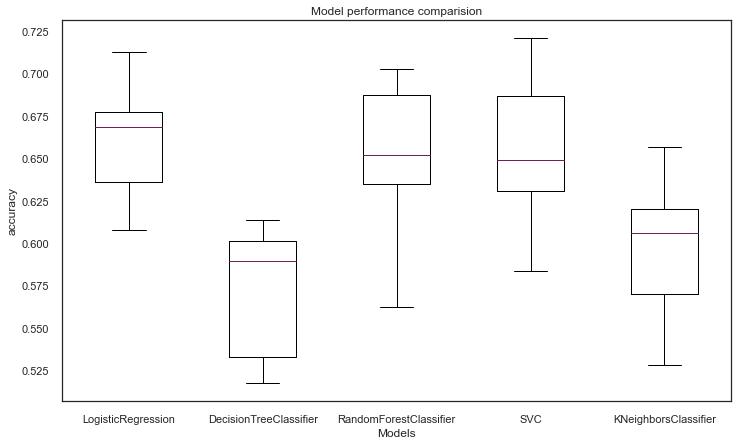

In [1459]:
plt.figure(figsize=(12,7))
plt.boxplot(x=results,labels=name)
plt.xlabel('Models')
plt.ylabel('accuracy')
plt.title('Model performance comparision')
plt.show()